In [ ]:
import glob
import os
import joblib
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [14]:
config_file = "../results/escape/model.yml"

In [15]:
with open(config_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [16]:
save_loc = conf["save_loc"]
inf_save_loc = conf["inference"]["data_set"]["name"]
path_to_preds = os.path.join(save_loc, inf_save_loc, "propagated")
distance_threshold = conf["inference"]["distance_threshold"]

In [17]:
load_fn = os.path.join(save_loc, inf_save_loc,
                       f"prediction_table_{str(distance_threshold)}.csv")

In [18]:
prediction_table = pd.read_csv(load_fn)

In [19]:
if "x_t" in prediction_table:
    prediction_table["x_t"] = prediction_table["x_t"] * (2 * 7300 / 4872) - 7300
    prediction_table["y_t"] = prediction_table["y_t"] * (2 * 4800 / 3248) - 4800
    prediction_table["d_t"] = 2.96 * prediction_table["d_t"] 
    prediction_table["x_p"] = prediction_table["x_p"] * (2 * 7300 / 4872) - 7300
    prediction_table["y_p"] = prediction_table["y_p"] * (2 * 4800 / 3248) - 4800
    prediction_table["d_p"] = 2.96 * prediction_table["d_p"] 
else:
    prediction_table["x_p"] = prediction_table["x"] * (2 * 7300 / 4872) - 7300
    prediction_table["y_p"] = prediction_table["y"] * (2 * 4800 / 3248) - 4800
    prediction_table["z_p"] = prediction_table["z"]
    prediction_table["d_p"] = 2.96 * prediction_table["d"]

### Create average histogram

In [20]:
bins = {'x': np.arange(-7300,7300, (7300--7300)//19),
        'y': np.arange(-4800,4800, (4800--4800)//19),
        'z': np.arange(14000,158000, (158000-14000)//20),
        'd': np.arange(0, 30, 2.96)}

widths = {'x': (7300--7300)//19,
          'y': (4800--4800)//19,
          'z': (158000-14000)//20,
          'd': 2.96}

In [21]:
h_range = prediction_table["h"].unique()

In [48]:
hist_avg = {}
for row in ("_t", "_p"):
    hist_avg[row] = {}
    for coord in ['x', 'y', 'z', 'd']:
        try:
            coord_row = coord + row
            hist = []
            for h_idx in h_range:
                c = prediction_table["h"] == h_idx
                not_nan = ~prediction_table[c][coord_row].isna()
                h, binEdges = np.histogram(prediction_table[c][coord_row][not_nan], bins=bins[coord])
                hist.append(h)
            hist_avg[row][coord] = np.stack(hist)
            hist_avg[row][coord+'_mean'] = np.stack(hist).mean(axis=0)
            hist_avg[row][coord+'_sum'] = np.stack(hist).sum(axis=0)
            hist_avg[row][coord+'_std'] = np.stack(hist).std(axis=0) / ((len(h_range) - 1) ** 0.5)
        except KeyError:
            continue

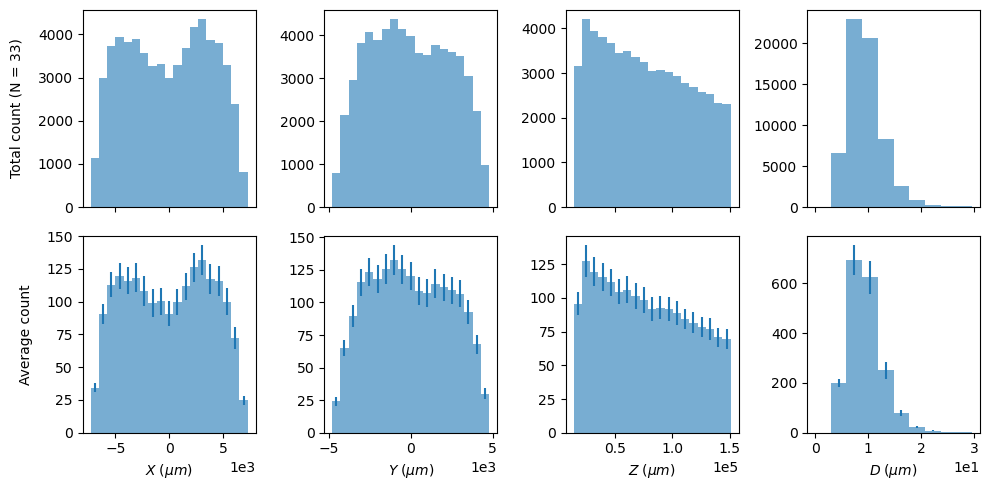

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='col', figsize=(10,5))

for i, coord in enumerate(['x', 'y', 'z', 'd']):
    _, binEdges = np.histogram(hist_avg["_p"][coord], bins=bins[coord])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    try:
        ax[1][i].bar(bincenters, hist_avg["_t"][f'{coord}_mean'], alpha=0.6, width=widths[coord], 
                     fill = True, #yerr=hist_avg['_t'][f'{coord}_std'],
                     color='#ff7f0e')#, ecolor='#ff7f0e')
    except KeyError: 
        pass
    ax[0][i].bar(bincenters, 
                 hist_avg['_p'][f'{coord}_sum'], alpha=0.6, width=widths[coord], 
                label='Predicted',
            fill=True, linewidth=2, color='#1f77b4', ecolor='#1f77b4')
    ax[1][i].bar(bincenters, 
                 hist_avg['_p'][f'{coord}_mean'], alpha=0.6, width=widths[coord], 
                label='Predicted', yerr=hist_avg['_p'][f'{coord}_std'],
            fill=True, linewidth=2, color='#1f77b4', ecolor='#1f77b4')
    
    ax[1][i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[1][i].locator_params(axis='x', nbins=4)
    
cols = ["$X\;({\mu}m)$", "$Y\;({\mu}m)$", "$Z\;({\mu}m)$", "$D\;({\mu}m)$"]
# rows = ["Neural Network", "Standard Method"]

for a, col in zip(ax[1], cols):
    a.set_xlabel(col)

ax[0][0].set_ylabel("Total count (N = 33)", rotation=90, labelpad=10)
ax[1][0].set_ylabel("Average count", rotation=90, labelpad=10)
#ax[3].legend(["True", "Predicted"])

fig.tight_layout()
fig.show()

In [46]:
summary = prediction_table.groupby("h").mean()[["x_p", "y_p", "z_p", "d_p"]]
summary["d_std"] = prediction_table.groupby("h").std()["d_p"]
summary["n_particles"] = [
    x[1] for x in sorted(prediction_table["h"].value_counts().to_dict().items(), key = lambda x: x[0])
]

In [47]:
summary

,x_p,y_p,z_p,d_p,d_std,n_particles
h,,,,,,
0,-1.950511,499.517794,77521.674235,9.488085,3.794617,224
1,68.952072,51.532687,86184.622387,11.425695,3.902394,2319
2,1382.503677,790.699918,110417.900000,9.628222,3.876933,12
3,-79.528359,52.231481,76578.773729,8.833028,3.248870,2504
4,228.162115,56.268748,80635.804447,10.065947,3.330656,3768
5,-56.845642,17.895618,80440.164505,9.649269,3.386888,3495
6,-77.803697,-4.013777,79362.975949,8.732790,3.277494,2828
7,-71.960512,0.784135,79755.739208,9.331596,3.473457,3105
8,-1009.384366,41.599654,76330.458378,7.062933,3.045250,370


In [82]:
summary["n_particles"].mean()

1888.3333333333333

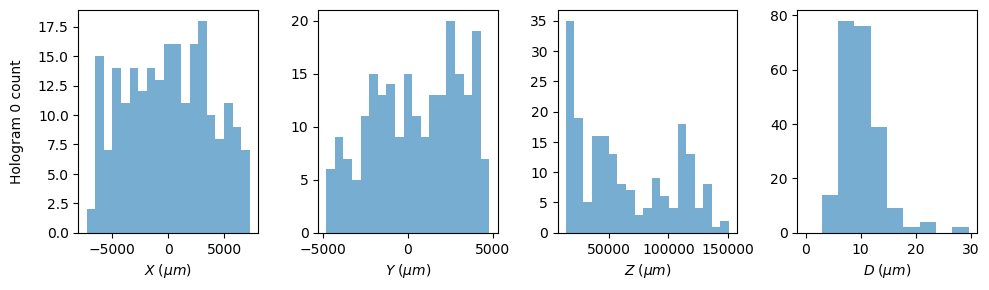

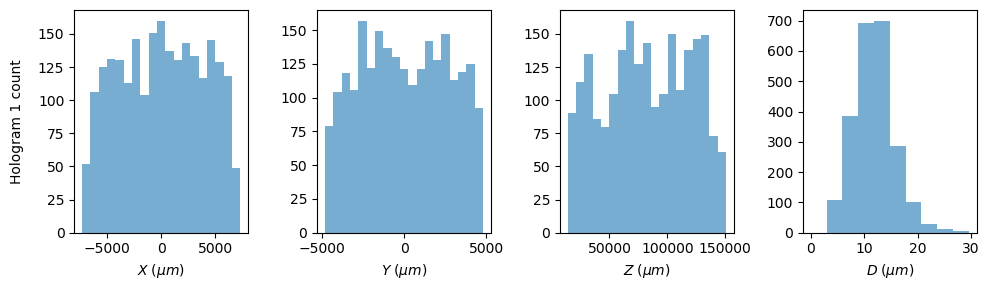

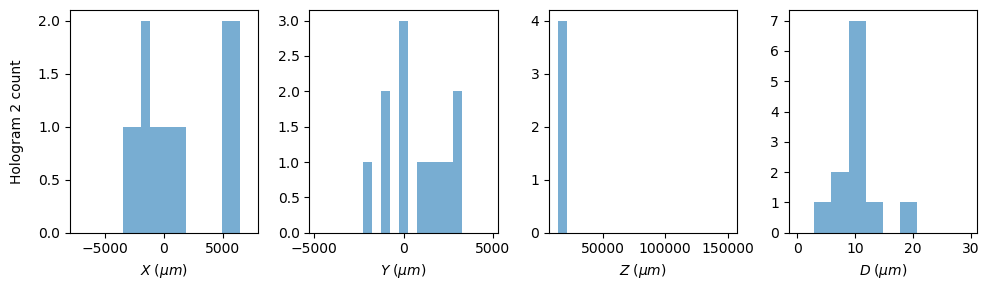

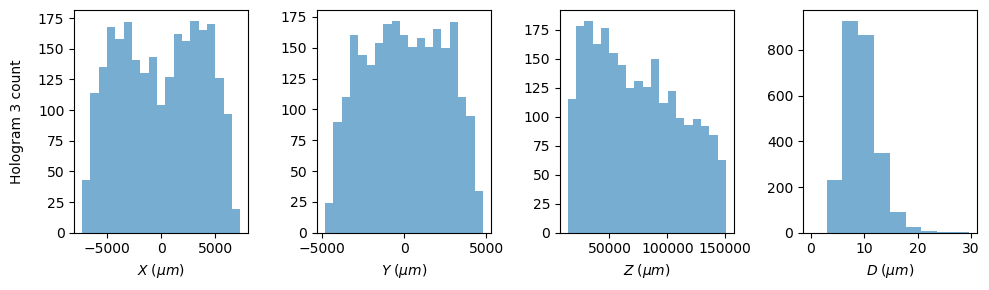

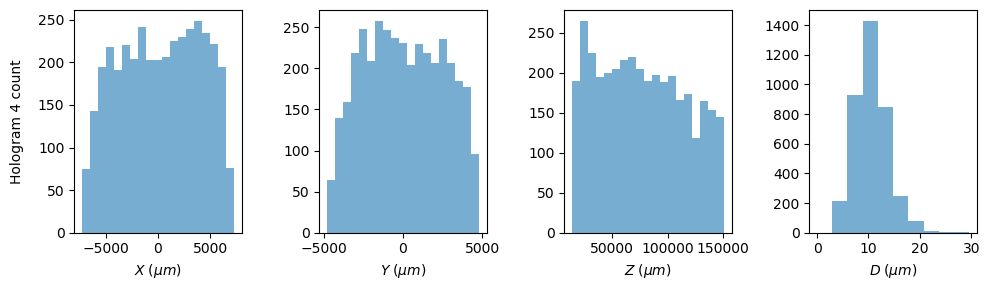

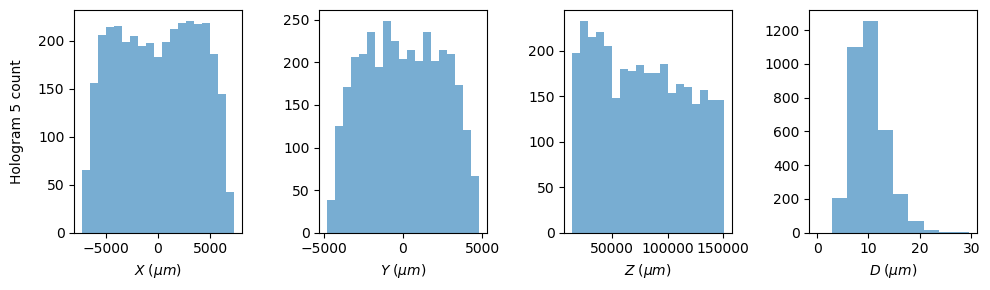

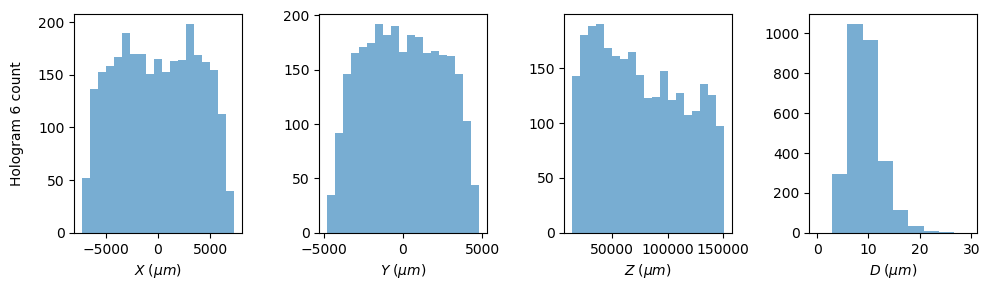

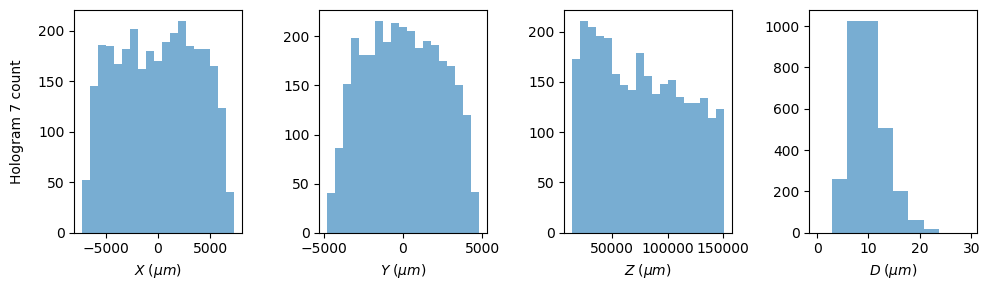

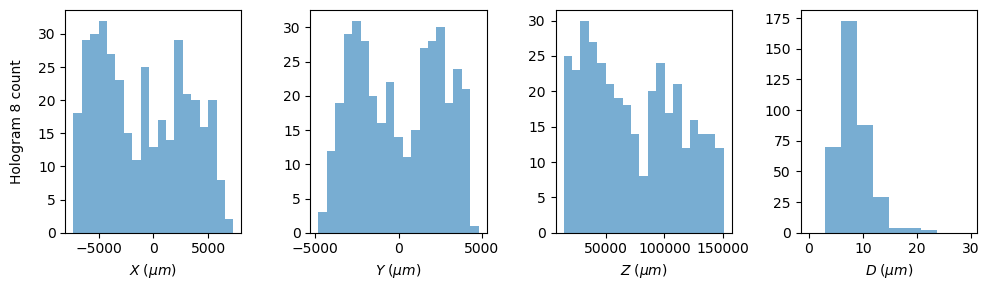

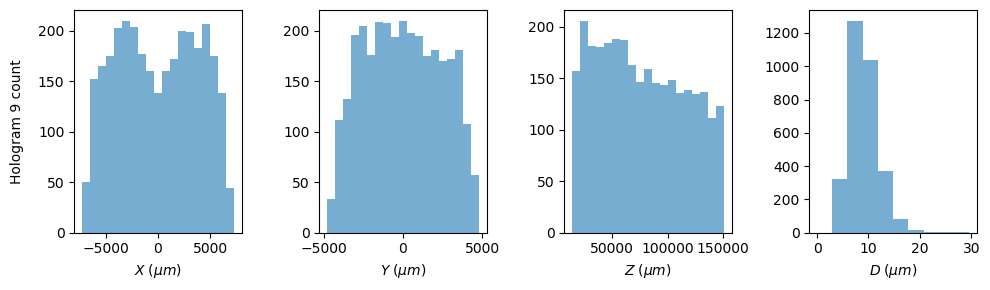

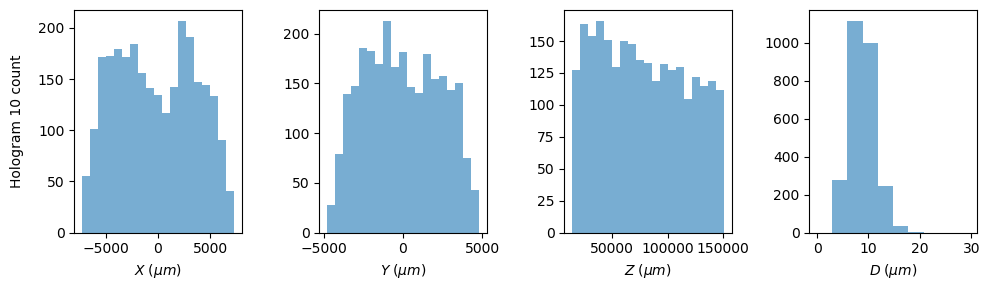

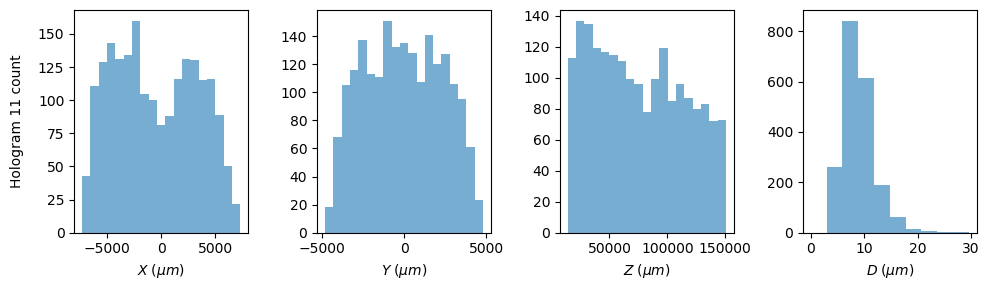

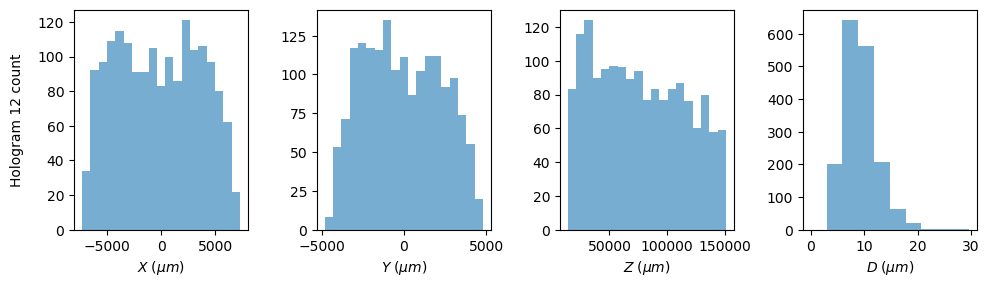

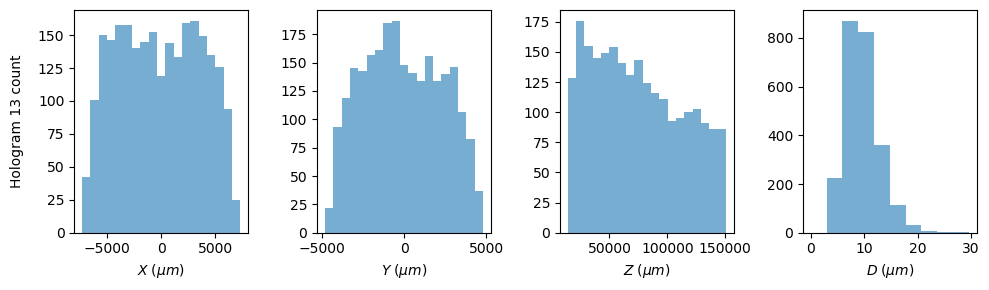

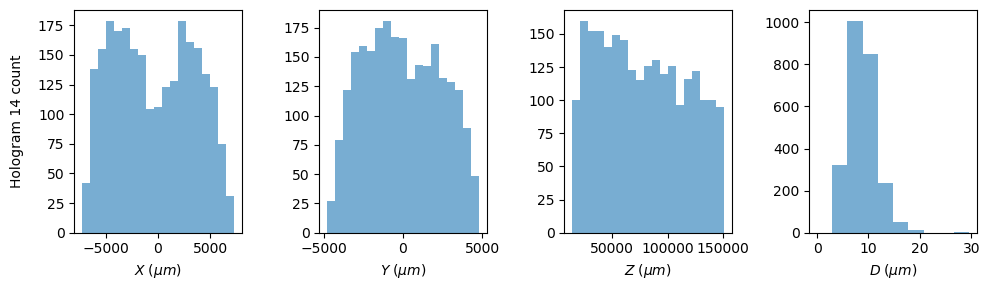

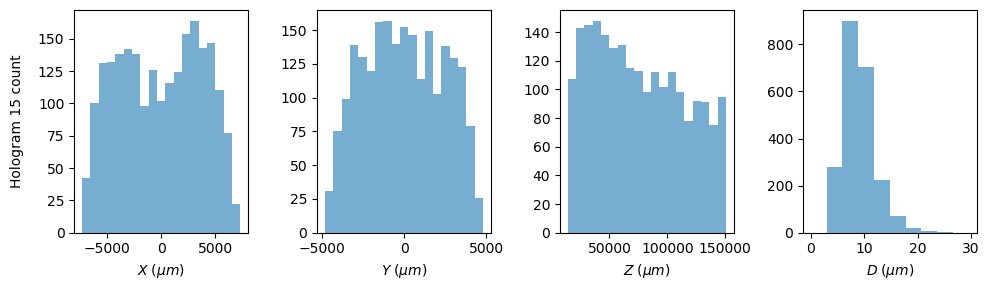

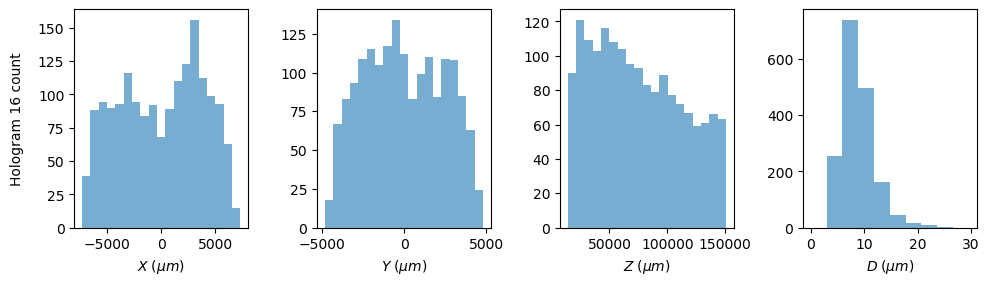

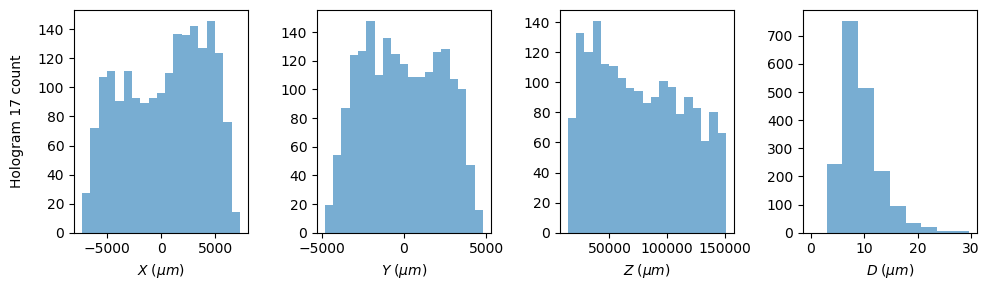

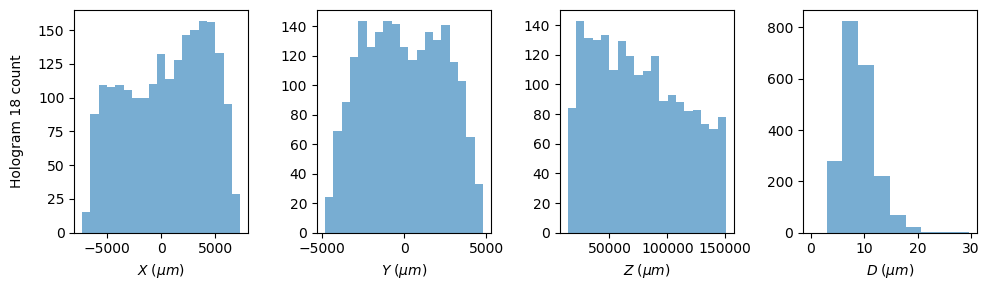

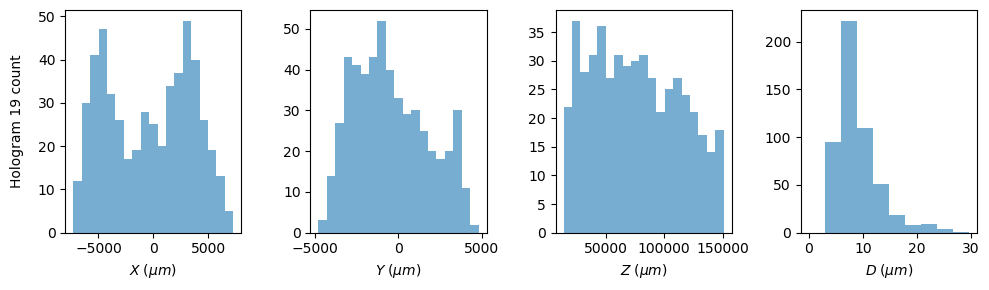

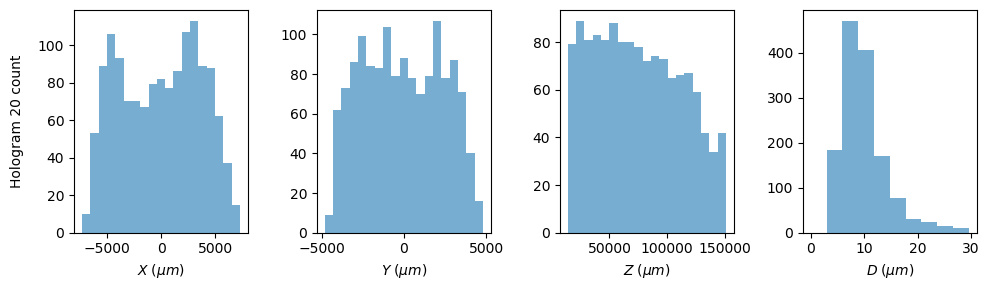

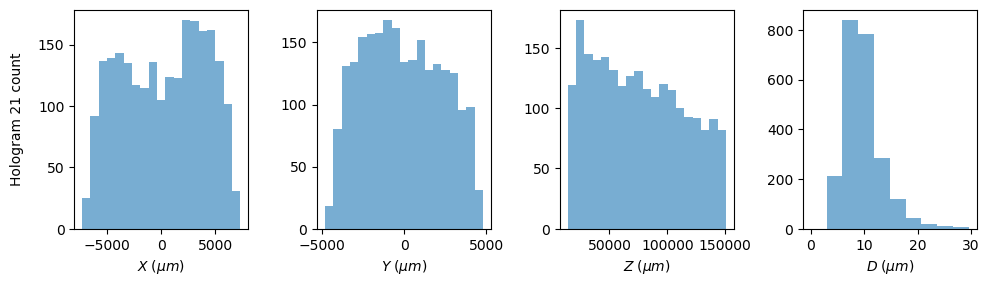

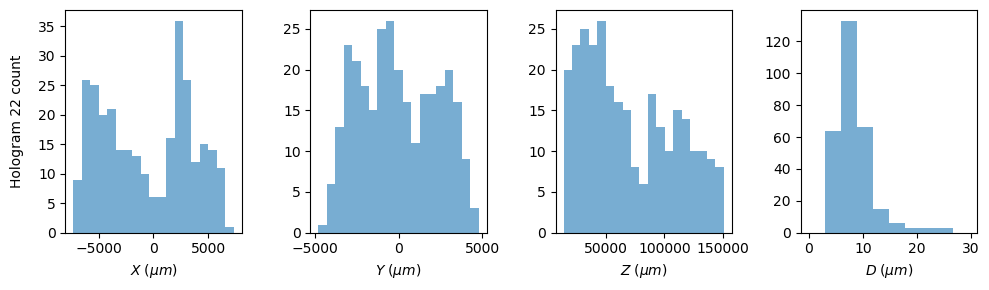

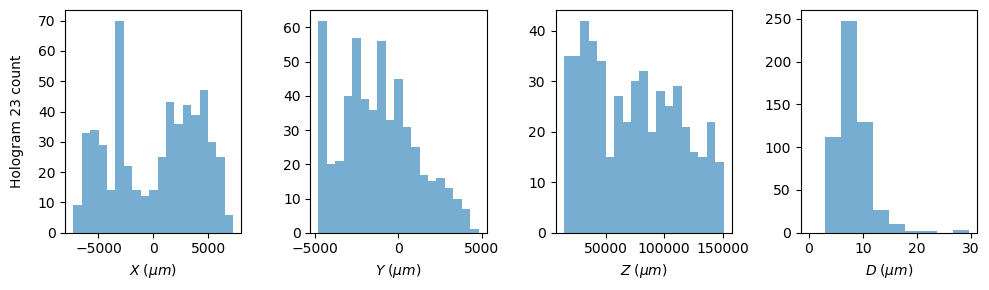

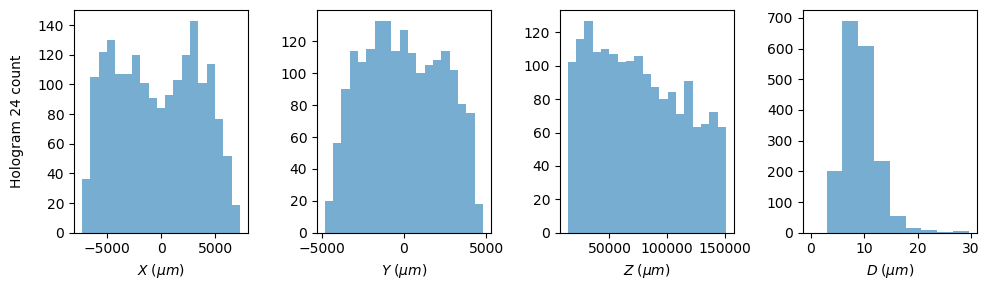

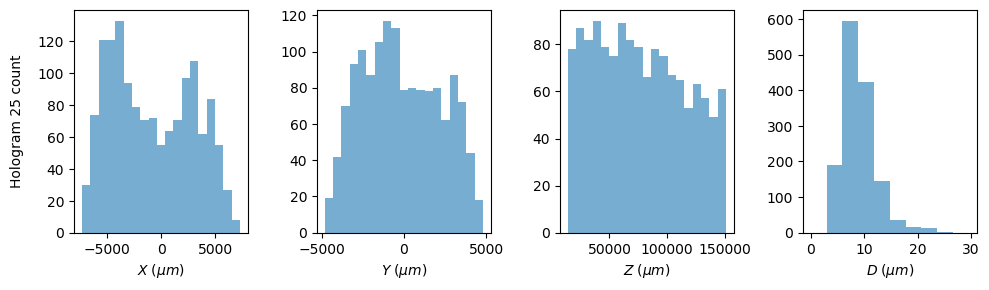

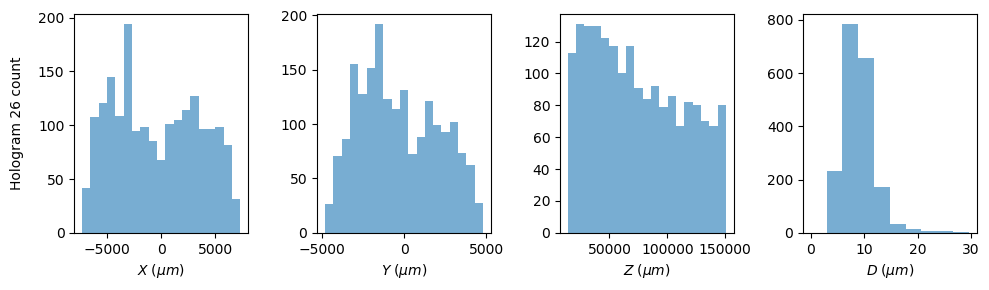

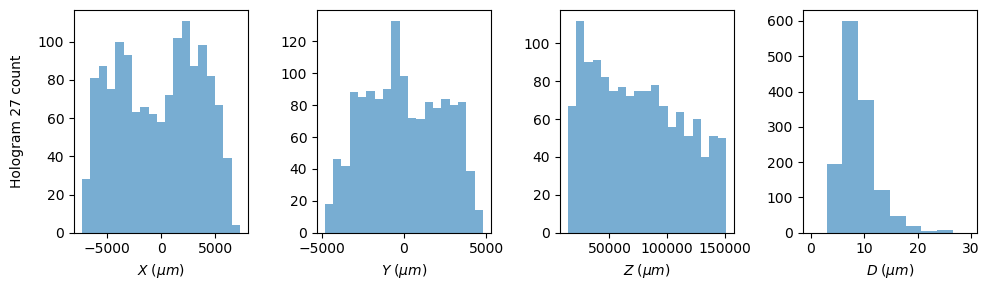

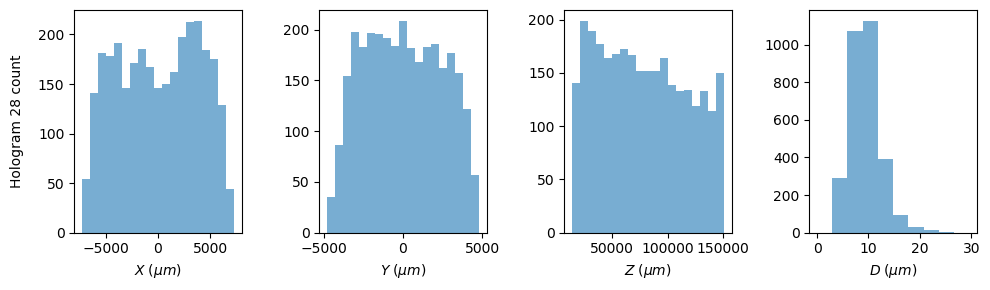

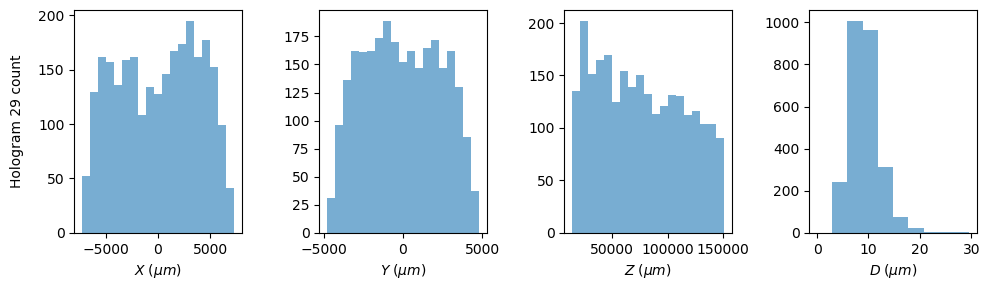

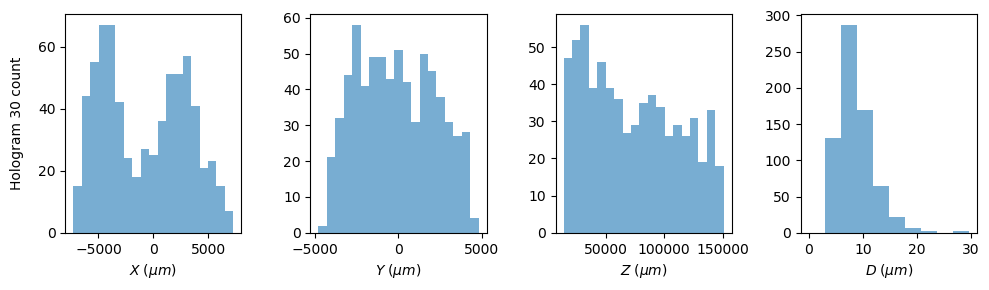

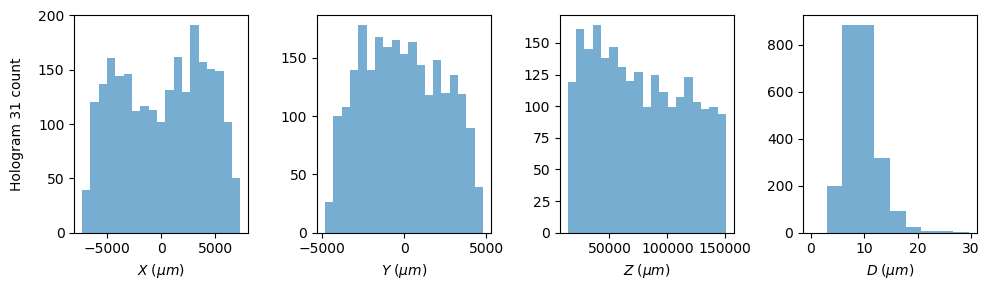

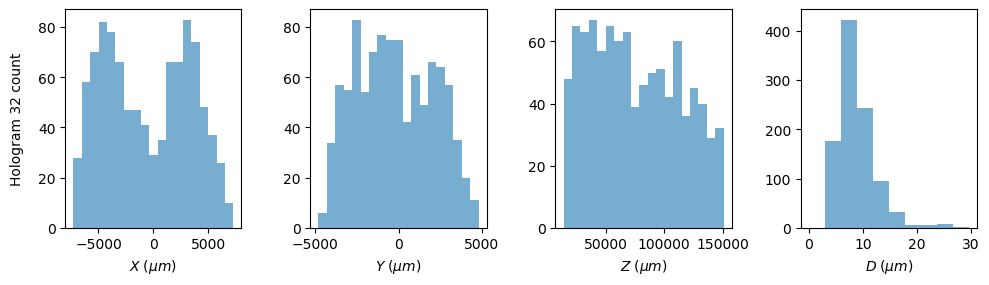

In [81]:
hist = []
for h_idx in h_range:
    c = prediction_table["h"] == h_idx
    fig, ax = plt.subplots(nrows=1, ncols=4, sharex='col', figsize=(10, 3))
    for i, coord in enumerate(['x', 'y', 'z', 'd']):
        coord_row = coord + "_p"
        not_nan = ~prediction_table[c][coord_row].isna()
        #print(prediction_table[c])
        h, binEdges = np.histogram(prediction_table[c][coord_row][not_nan], bins=bins[coord])
        _, binEdges = np.histogram(h, bins=bins[coord])
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        ax[i].bar(bincenters,
                  h, alpha=0.6, width=widths[coord],
                  label='Predicted', fill=True, linewidth=2, color='#1f77b4', ecolor='#1f77b4')
    cols = ["$X\;({\mu}m)$", "$Y\;({\mu}m)$", "$Z\;({\mu}m)$", "$D\;({\mu}m)$"]
    for a, col in zip(ax, cols):
        a.set_xlabel(col)

    ax[0].set_ylabel(f"Hologram {h_idx} count", rotation=90, labelpad=10)
    fig.tight_layout()
    plt.show()

### Plot in 3D

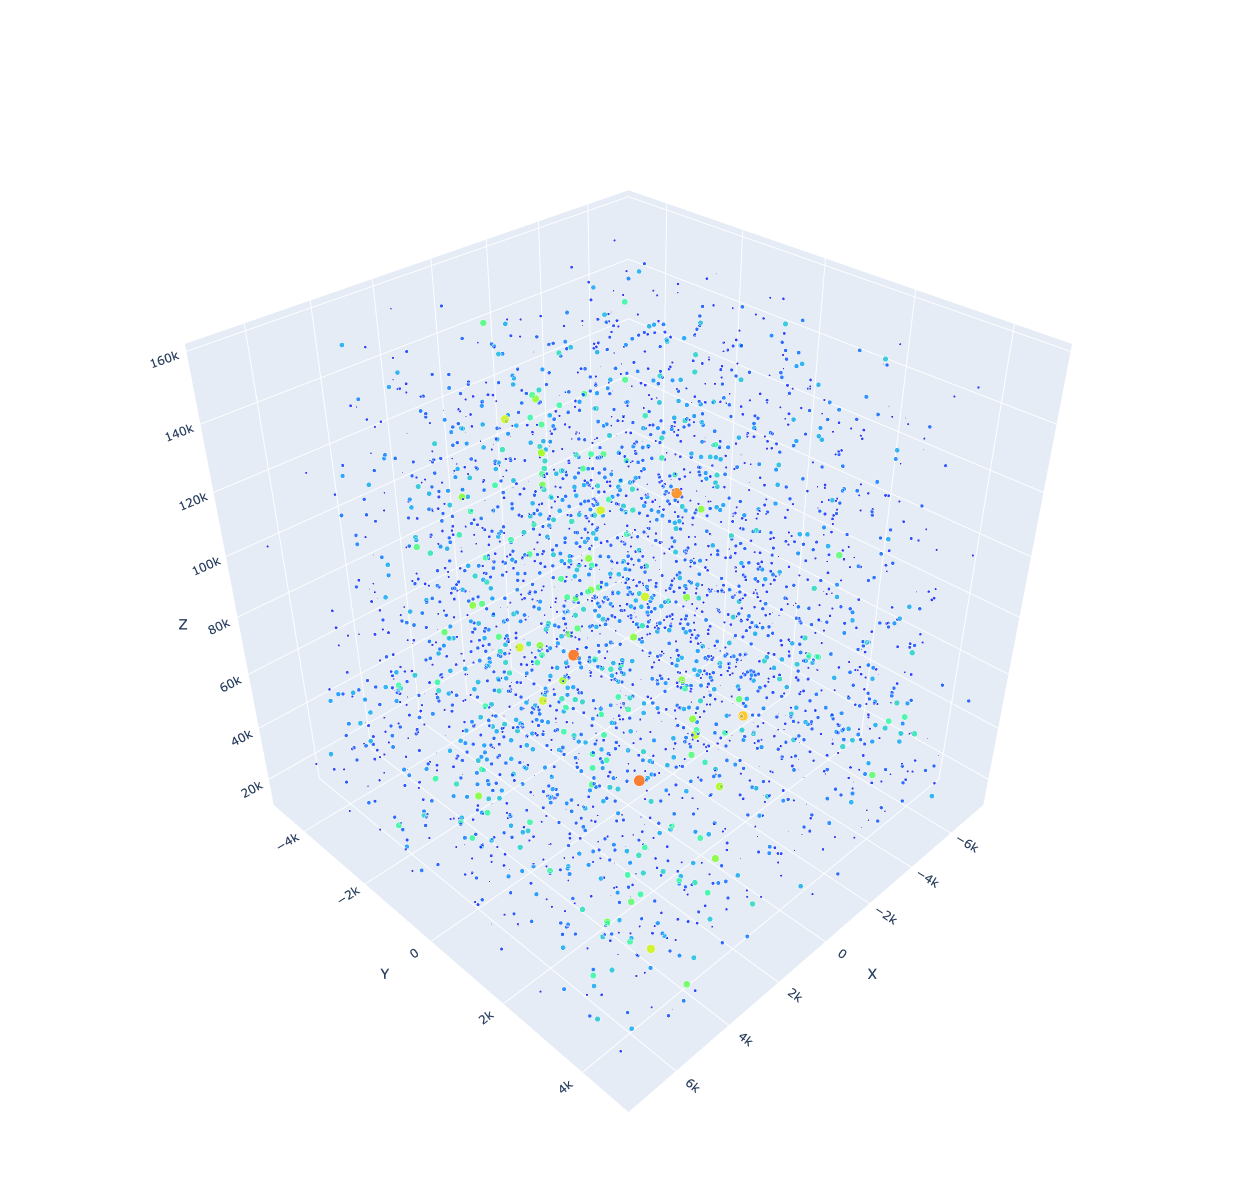

In [25]:
h_idx = 9
c = prediction_table["h"] == h_idx

data = go.Scatter3d(x=prediction_table[c]['x_p'],
                    y=prediction_table[c]['y_p'],
                    z=prediction_table[c]['z_p'],
                    mode='markers',
                    marker=dict(size=prediction_table[c]['d_p']/2,
                                color=prediction_table[c]['d_p'],
                                colorscale='Rainbow',
                                cmin=0,
                                cmax=30,
                                opacity=0.8))

layout = go.Layout(width=1200,
                   height=1200)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(scene=dict(xaxis_title='X',
                             xaxis_tickformat='s',
                             yaxis_title='Y',
                             yaxis_tickformat='s',
                             zaxis_title='Z',
                             zaxis_tickformat='s'),
                  scene_camera=dict(up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=0),
                                    eye=dict(x=1.5, y=1.5, z=1.5)),
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  margin=dict(l=0, r=0, t=0, b=0, pad=0))

#fig.write_image(f"paper_figures/3D_{h_idx}_{true}_holosuite.png", format='png')
#fig.write_image(f"paper_figures/3D_{h_idx}_{true}_holosuite.pdf", format='pdf')
fig.show()